# Create Model Data for N-Number of Residential Solar-PV Prosumers in the Florida Power & Light Service Territory 

## Description:
Provide a simulation of prosumers (users that can provide generation), specifically for the FPL Territory by utilizing public government information. The methodology would take into account average curves in the published data and normalize it in order to simulate what an individual prosumers consumption and generation would be given averages states by common litterature. (i.e the average consumption of a typical home in south florida, and the generation capacity of the typical installation of PV solar). With the typical averages of a prosumer and the normalized curves we can synthesize a typical prosumer in the FPL territory. The final step would be to add variance to the consumption and generation profiles for each prosumer to simulate evironmental and behvaioural differences of each unique home. The final output would be a series of prosumers interacting with the grid to for consumption and providing net energy when solar generation is sufficient.

## Steps:
### 1. Data Gathering 
    - Shows the steps taken to acquire the data from EIA.gov
    - Validation of collected data with other resources , ie. NREL

### 2. Data Cleansing
    - Conversion of units, normalization and joing of datasets
    
### 3. Build Model from Data
    - Implement statistical variations to curves
    - Create individual prosumer models and save to csv file


In [1]:
#import data from sources
import pandas as pd
from functools import reduce
import requests 
import os
import pathlib
from datetime import datetime
import matplotlib.pyplot as plt
from numpy import random
from tabulate import tabulate
import math

# Step 1 : Data Gathering
## 1.1 Collecting Data Programatically from EIA
The Energy Information Administration (EIA) is the statistical agency of the Department of Energy. It provides policy-independent data, forecasts, and analyses to promote sound policy making, efficient markets, and public understanding regarding energy, and its interaction with the economy and the environment. They provide an API (Application Programmable Interface) for gathering historical data. The data is provided to users through the use of an API key and crafted URL queries. More information on the API and its query parameters can be found here (http://api.eia.gov/series/). 

The simulation is focused on gathering datasets specifically from Florida. The datasets that the simulation will utilize are residential demand, generation from distributied photo-voltaic solar energy (roof-top solar), and residential price of electricity. The datasets provide these in particular formatting and scale that requires conditioning. THe condintioning step is referenced as "Data Wrangling" and is discussed further in latter sections.

- Call EIA.gov API
    - Set the api key 
    - Set the start and end month in 'YYYYMM' format

In [2]:
# Data Gathering Settings
start ='201910'
end = '202012'

class Dataset:
    def __init__(self, name, query,start,end):
        self.name = name
        self.query = query
        self.start =start
        self.end = end
        self.df = self.fetch()
    def plot(self):
        self.df.plot(x='time',title=f"FL. Residential ({self.name})")
    def convert(self,unit):
        self.df[self.name] = self.df[self.name].apply(lambda x: x*unit)
    def normalize(self):
        self.df[self.name] = self.df[self.name].apply(lambda x: x/self.df[self.name].max())
        #self.df= self.df.sort_values(by=['time'])
    def fetch(self):
        eia_url = 'http://api.eia.gov/series/'
        api_key='d42ebe76b736d7815489e3298ff17079'
        self.url = f'{eia_url}?api_key={api_key}&series_id={self.query}&start={self.start}&end={self.end}'
        data = requests.get(self.url).json()['series'][0]['data']
        df = pd.DataFrame(data,columns=['time',self.name])
        df['time'] =  pd.to_datetime(df['time'], format='%Y%m')
        return df


demand = Dataset(name='demand',query='ELEC.SALES.FL-RES.M',start=start,end=end) 
generation = Dataset(name='generation',query='ELEC.GEN.DPV-FL-8.M',start=start,end=end)
price = Dataset(name='price',query='ELEC.PRICE.FL-RES.M',start=start,end=end)

## 1.2 Validating Data
### 1.2.1 Net Generation of Residential Small-Scale PV Solar

*The plot retreived from the generation data shows the peak of generation in Florida to be in the month of May. The data provided by the EIA is in accordance with reports collected by NREL DNI maps.*

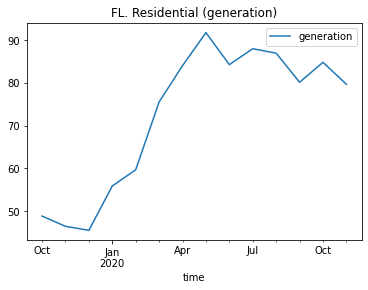

In [3]:
generation.plot()



Every PV Solar installation is different and will have a different net-generation curve. Systems can suffer from tree shading, orientation, and other external factors. According to the National Renewable Energy Labs' PVWATTS estimator, which takes decades of weather data and solar irradiance estimates to plot the output from a given solar energy system based on a set of assumption, the best time for solar energy production in Florida is spring. East facing systems will outperform a west facing system primarily because of afternoon rain showers in the late spring and summer. The east facing systems gather most of their energy in the relatively clear morning hours. An east facing system will produce about 9% less than a south facing system. A west facing system will produce about 11% less than a south facing system. Pitching panels in a manner that is not parallel to a roof surface costs more than the gains that would be achieved, and reduces total available roof space (because rows of pitched modules need to be spaced to avoid shading) [[1](https://floridasolardesigngroup.com/the-best-time-of-year-for-solar-power-in-florida/#:~:text=The%20days%20are%20much%20longer,amount%20of%20light%20each%20day.)]. In summary the best time of year for solar power in Florida is spring, and the annual variation in solar production is dependent on the orientation of solar panels. 

The National Renewable Energy Laboratory (NREL) specializes in the research and development of renewable energy, energy efficiency, energy systems integration, and sustainable transportation. They provide a [DNI](https://en.wikipedia.org/wiki/Solar_irradiance)(Direct Normal Solar Irradiance)model that provides the generation expected from Solar at various areas in north america. Direct Normal Irradiance (DNI) is the amount of solar radiation received per unit area by a surface that is always held perpendicular (or normal) to the rays that come in a straight line from the direction of the sun at its current position in the sky.The maps shown provide annual average daily total solar resource using 1988-2016 data (PSM v3) covering 0.038-degree latitude by 0.038-degree longitude (nominally 4km x 4km). [NREL](https://nsrdb.nrel.gov) The model from NREL confirms the assumptions that during the months of March, April and May are peak months for solar generation in almost the entire Florida region. A very sharp decline in DNI is seen during the month of June and other summer months. The counter-intuitive realization here is that even if summer days are longer and provide more exposure to the sun the irridiance is not as strong. 

![May DNI Map from NREL](img/full_map.jpg)




### Florida DNI
Analysis of just the state of florida can show us a trend of DNI over the year. This data was extracted and as an average range from the NREL DNI charts.
#### Florida DNI During The Month of May (Annualized 1998-2016)
![May DNI Map from NREL](img/map_florida_dni/solar-may-dni-florida.png)


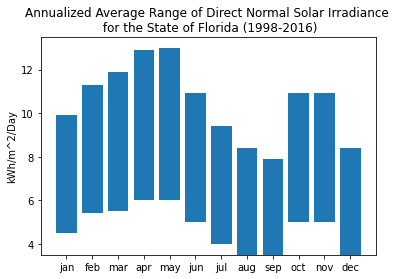

In [4]:
fl_dni_plot_title = 'Annualized Average Range of Direct Normal Solar Irradiance \n for the State of Florida (1998-2016)'
fl_dni_max_data = [5.4,5.9,6.4,6.9,7.0,5.9,5.4,4.9,4.4,5.9,5.9,4.9]
fl_dni_min_data = [4.5,5.4,5.5,6.0,6.0,5.0,4.0,3.5,3.5,5.0,5.0,3.5]
fl_dni_x = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

plt.bar(fl_dni_x,fl_dni_max_data, bottom=fl_dni_min_data)
plt.ylabel('kWh/m^2/Day')
plt.title(fl_dni_plot_title)
plt.show()

### 1.2.2 Validation of Residential Electricity Retail Monthly Price

The residential pricing plot shows a significant dip from above 11.5 cents to below 10 cents this correlates well with the pandemic relief provided by FPL (Florida Power & Light) for the month of May. The FPL utility provided 25% discount on electricity consumed in May. [Sun-Sentinel](https://www.sun-sentinel.com/coronavirus/fl-bz-fpl-25-percent-discount-request-approved-20200428-pbhivoskcjdovkg77tbvakbaqy-story.html)



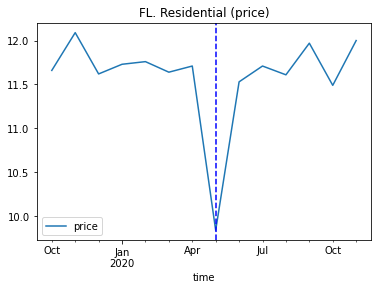

In [5]:
price.plot()
# only one line may be specified; full height 
plt.axvline(x = '202005', color = 'b', label = 'May, Price Reduction (Pandemic Relief)',linestyle='dashed')
plt.show()

# Step 2 :  Data Cleansing

## 2.1 Conversion of Units to kWh
- Average Consumption Dataset :
    - Retail sales of electricity, Florida, residential, monthly
    - Units in Million Kilowatthours
    - Conversion to kWh : X_kWh = (X * 10^6)

- Average Prosumer Generation Dataset :
    - Net generation, small-scale solar photovoltaic, Florida , residential, monthly
    - Units in thousand megawatthours
    - Conversion to kWh : X_kWh = (X * 10^3 * 10^3)
    
- Average  Price Dataset:
    - Average retail price of electricity, Florida, monthly
    - Units in cents per Kilowatthour
    - Conversion to cents/kWh : X_cents/kWh = X_cents/kWh

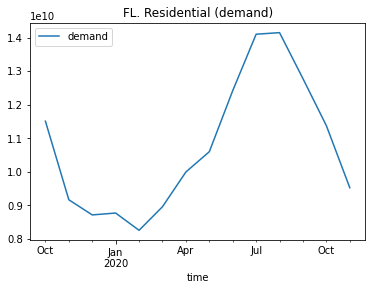

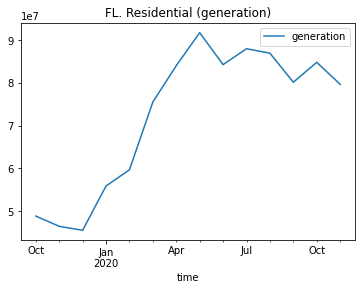

In [6]:
demand.convert(pow(10,6))
generation.convert(pow(10,6))
#price.convert(1) #No conversion required
demand.plot()
generation.plot()

## 2.2 Normalize & Join Data

**How to combine?** The datasets for generation, demand and price will be joined on the "time" stamp for year and month.

**Why Normalize?** The datasets are provided as an average of all of Florida. Since the simulation requires single prosumers to be synthesized from the average curve of all Florida residents the normalized curve will then be used to generate randomly an individuals curve about the normal curve. The statistical variance away from the normal curve can be adjusted to simulate the variability of a single prosumer. The same can be done for N number of prosumers. 

**Pricing?** The prices for retial electricity each month will be used to create profits for the prosumers. These prices will be used as is and will not need to be normalized. 


         time    demand  generation  price
0  2020-11-01  0.672893    0.868196  12.00
1  2020-10-01  0.803816    0.924304  11.49
2  2020-09-01  0.902985    0.873409  11.97
3  2020-08-01  1.000000    0.947582  11.61
4  2020-07-01  0.996674    0.958952  11.71
5  2020-06-01  0.877596    0.918344  11.53
6  2020-05-01  0.748825    1.000000   9.84
7  2020-04-01  0.706091    0.915735  11.71
8  2020-03-01  0.632822    0.823069  11.64
9  2020-02-01  0.583059    0.650020  11.76
10 2020-01-01  0.619526    0.608698  11.73
11 2019-12-01  0.615537    0.495571  11.62
12 2019-11-01  0.647484    0.505783  12.09
13 2019-10-01  0.813208    0.531894  11.66


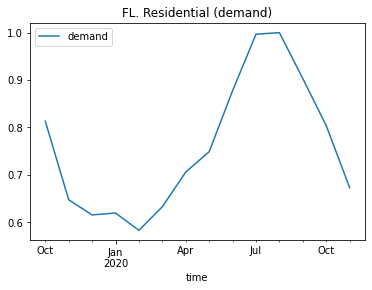

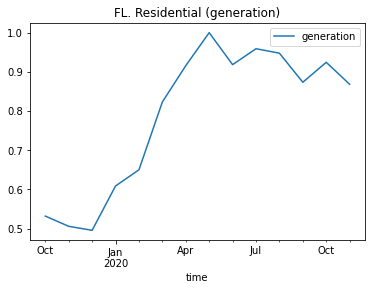

In [7]:
# normalize the dataset from 0.0-1.0
demand.normalize()
generation.normalize()
demand.plot()
generation.plot()

# merge the datasets by time column
df = reduce(lambda left,right: pd.merge(left,right,on=['time'],how='outer'), [demand.df , generation.df, price.df])
print(df)

# Step 3 : Build Model from Data
## 3.1 Synthesizing Individual Prosumer Data From Ensemble Datasets

> Typical individual consumption per month in florida : 1100kWh/mo.

The datasets collected are monthly averages rolled up for the entire state of florida. 
The florida data can be used as a baseline to show variations each month from a norm.
The average consumer demand in florida was estimated to be 1100kWh a month. Since we have a percentage of the average home usage we can use it as our baseline deviation from norm. 

> Typical individual solar generation per month in florida : (10kW) * 4hr*30days = 1200kWh/mo.

Most florida prosumers are using residential PV installations that are considered Tier 1, less than 10kW AC capacity. By multiplying the possible generation accross the hours of optimum daylight each day (assumption made from surveys) (4 hours * ~30days) we can arrive at an approximate normal capacity for a typical home at around 1200kWh a month. The florida regulations for net metering prohibits the generation of more than 115% of the homes consumption. This limitation fits the benchmarks chosen for an everage prosumers generation, in this case (1,125kWh/mo.).

The randomized curves are generated from the normalized curve. The function "get_random_curve" shows how the new curves for the prosumers will be created. 


### 3.1.1 Define Prosumer 
- The prosumer object can be designed to have the generation,demand,consumption,net-energy curves as properties. The first two would be generated from the normal curves randomly while the last two will be calculated from the previous ones.

### 3.1.2 Calculate Prosumer Net-Energy Data
- Create net-energy values by taking difference in the generation and demand for each prosumer that is positive. This represents the prosumers excess generation to the grid.

### 3.1.3 Calculate Prosumer Consumption Data
- Create consumption values by taking the negative values of the difference between the generation and demand. This represents the prosumers consumption from the grid to meet the required demand for the prosumer that is not met by the solar production. 

In [8]:
class Prosumer:
    def __init__(self, id, gen, dem, price):
        self.id = id
        self.generation = gen
        self.demand = dem
        self.price = price
        diff = self.demand['demand'] - self.generation['generation']
        consumption = [max(x,0) for x in diff]
        net_energy = [min(x,0) for x in  diff]
        self.consumption = pd.DataFrame(list(zip(self.generation['time'],consumption)),columns=['time','consumption'])
        self.net_energy = pd.DataFrame(list(zip(self.generation['time'],net_energy)),columns=['time','net_energy'])
        self.data = reduce(lambda left,right: pd.merge(left,right,on=['time'],how='outer'), [self.demand , self.generation, self.consumption, self.net_energy,self.price])
    def table(self):
        #print(f"\nProsumer:{prosumer['id']}")
        print(tabulate(self.data, headers = 'keys', tablefmt = 'github',showindex=False))
    def data_w_id(self):
        data_w_id = self.data
        data_w_id["id"] = self.id
        return data_w_id
    def plot(self):
        # plot all curve associated with prosumer
        self.data.plot(x='time',y=['demand','generation','consumption','net_energy'],title=f"FL. Synthesized Dataset - Prosumer:{self.id}")

In [9]:
# Given statistical arguments , converts an original dataframe curve with 'time' value and col of args['type'] to
# randomly sampled equivalent given the args['std'],args[llim],args[ulim],args['mean'] values.
def get_random_curve(args,curve):
    c = [max(args['llim'],min(args['ulim'],random.normal(loc=args['mean'],scale=args['std'])*x)) for x in curve[args['type']]]
    return pd.DataFrame(list(zip(curve['time'],c)),columns=['time',args['type']])

In [10]:
# Generate prosumers based on normalized curves from data gethering stage
def get_prosumers(N,gen_args,dem_args,gen_df,dem_df,price_df):
    prosumers = []
    for n in range(N):
        prosumers.append(
            Prosumer(id=n+1,
                    gen=get_random_curve(args=gen_args,curve=gen_df),
                    dem=get_random_curve(args=dem_args,curve=dem_df),
                    price=price_df))
    return prosumers

In [11]:
# Generate a collection of prosumers

N = 100 # Number of prosumers to create
tier1_gen ={
            'type':'generation',
            'mean':1200,
            'std': 1200 * 0.2, #20% of mean,
            'ulim':1200, # upper limit (capacity),
            'llim':0 # lower limit
            } 

#A 100kW Solar Kit requires up to 6,500 square feet of space. 100kW or 100 kilowatts is 100,000 watts of DC //#direct current power. This could produce an estimated 12,000 kilowatt hours (kWh) of alternating current (AC) #power per month, assuming at least 5 sun hours per day with the solar array facing South.
tier2_gen ={
            'type':'generation',
            'mean':12000,
            'std': 12000 * 0.2, #20% of mean,
            'ulim':12000, # upper limit (capacity),
            'llim':0 # lower limit
            } 

prosumers = get_prosumers(N, 
                    gen_args=tier2_gen,
                    gen_df=generation.df, 
                    dem_args= {   
                    'type':'demand',
                    'mean':1100,
                    'std': 1100 * 0.2, #20% of mean
                    'ulim':1100 * 2, # upper limit (max load),
                    'llim':1100 * 0.1 # lower limit (constant load) 
                    },
                    dem_df=demand.df,
                    price_df=price.df)

## 3.2 Analysis of Prosumer Data

### 3.2.1 Validating Generated Data for All Prosumers 
- Demand curves follow the mean demand curve for the ensemble data collected.
- Generation curves are bounded by upper bound parameters set for the simulation to act as maximum capacity of the solar PV system.
- Consumption curves are positive values that show the required energy consumed by the prosumer from the Grid. 
- Net-Energy curve is negative indicating the power put back on the grid, this power would be subject to profit from net-metering.

def get_curve_accross_prosumers(type_name):
    prosumers_arr = []
    for prosumer in prosumers:
        prosumers_arr.append(
            pd.DataFrame(list(zip(prosumer.data['time'],prosumer.data[type_name])),columns=['time',f'Prosumer:{prosumer.id}']))
    return reduce(lambda left,right: pd.merge(left,right,on=['time'],how='outer'), prosumers_arr)


get_curve_accross_prosumers('demand').plot(x='time',title=f"(kWh/mo) Demand of N={len(prosumers)} Prosumers")
get_curve_accross_prosumers('generation').plot(x='time',title=f"(kWh/mo) Generation of N={len(prosumers)} Prosumers")
get_curve_accross_prosumers('consumption').plot(x='time',title=f"(kWh/mo) Consumption of N={len(prosumers)} Prosumers")
get_curve_accross_prosumers('net_energy').plot(x='time',title=f"(kWh/mo) Net Energy of N={len(prosumers)} Prosumers")

plt.show()

### 3.2.2 Validating Individual Prosumer Data 
- The variance from the normal curve is within the set tolerances
- The average demand and generation coincide with the ensemble data
- The net energy is opposite to the consumption for each home
- The average performance of generation seems logical and consistent with the claims made for residential solar PV system (able to offset most of the homes usage but not all) 

for prosumer in prosumers:
    prosumer.plot()

In [12]:
all_prosumers_data = pd.DataFrame({})

for prosumer in prosumers:
    prosumer.table()
    all_prosumers_data = all_prosumers_data.append(prosumer.data_w_id(), ignore_index = True)

#Export the data to local csv
all_prosumers_data.to_csv(f'data/prosumer_N{N}_model_{datetime.today().strftime("%Y%m%d_%H%M")}.csv',index=False)





0 |  814.429 |     11062.3  |             0 |    -10247.9  |   11.97 |
| 2020-08-01 00:00:00 | 1091.36  |      7887.94 |             0 |     -6796.57 |   11.61 |
| 2020-07-01 00:00:00 |  942.22  |     10353.9  |             0 |     -9411.64 |   11.71 |
| 2020-06-01 00:00:00 |  944.728 |     12000    |             0 |    -11055.3  |   11.53 |
| 2020-05-01 00:00:00 |  666.05  |     12000    |             0 |    -11333.9  |    9.84 |
| 2020-04-01 00:00:00 |  732.582 |      8508.27 |             0 |     -7775.69 |   11.71 |
| 2020-03-01 00:00:00 |  699.205 |      8302.45 |             0 |     -7603.24 |   11.64 |
| 2020-02-01 00:00:00 |  656.052 |      8474.11 |             0 |     -7818.06 |   11.76 |
| 2020-01-01 00:00:00 |  765.058 |      6512.54 |             0 |     -5747.48 |   11.73 |
| 2019-12-01 00:00:00 |  426.843 |      6035.57 |             0 |     -5608.73 |   11.62 |
| 2019-11-01 00:00:00 |  668.067 |      5774.37 |             0 |     -5106.31 |   12.09 |
| 2019-10-01 00:00: